In [9]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [3]:
filename = 'ofd.out'

data = {}
with open(filename, "rb") as f:
    # Title (256 characters)
    data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

    # Read multiple ints (15 in total). NN is 8-byte, so use 'q' instead of 'i'.
    fmt = "<iiiiiiiqiiiiiiiidii"
    sz = struct.calcsize(fmt)
    ints = struct.unpack(fmt, f.read(sz))
    (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
     NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
     Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]

    # --- Read planewave_t ---
    # typedef struct {
    #    double theta, phi;
    #    double ei[3], hi[3];
    #    double ri[3], r0[3], ai;
    #    int pol;
    # } planewave_t;
    fmt = "2d 3d 3d 3d 3d d i"
    planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    data["Planewave"] = planewave

    fmt = "i"
    temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    
    # --- Read arrays with numpy ---
    def read_array(dtype, count):
        byte_size = np.dtype(dtype).itemsize * count
        return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)

    data["Xn"] = read_array(np.float64, Nx + 1)
    data["Yn"] = read_array(np.float64, Ny + 1)
    data["Zn"] = read_array(np.float64, Nz + 1)

    data["Xc"] = read_array(np.float64, Nx)
    data["Yc"] = read_array(np.float64, Ny)
    data["Zc"] = read_array(np.float64, Nz)

    data["Eiter"] = read_array(np.float64, Niter)
    data["Hiter"] = read_array(np.float64, Niter)

    data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))

    data["Freq1"] = read_array(np.float64, NFreq1)
    data["Freq2"] = read_array(np.float64, NFreq2)

    # --- Read feed_t ---
    # feed_t {
    #    char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
    # }
    feed_fmt = "c 3i 3d 3d"
    feed_size = struct.calcsize(feed_fmt)
    Feed = []
    for _ in range(NFeed):
        Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
    data["Feed"] = Feed

    # complex (double,double)
    data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
    data["Ref"] = read_array(np.float64, NFeed * NFreq1)

    data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
    data["Pin1"] = read_array(np.float64, NFeed * NFreq2)

    data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
    data["Gline"] = read_array(np.float64, NGline * 2 * 3)

    # --- Surface ---
    NSurface = struct.unpack("i", f.read(4))[0]

    # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
    surf_fmt = "7d"
    surf_size = struct.calcsize(surf_fmt)
    Surface = []
    for _ in range(NSurface):
        Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
    data["Surface"] = Surface

    # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
    SurfaceData = {}
    for ifreq in range(NFreq2):
        SurfaceData[ifreq] = {
            "Ex": read_array(np.complex128, NSurface),
            "Ey": read_array(np.complex128, NSurface),
            "Ez": read_array(np.complex128, NSurface),
            "Hx": read_array(np.complex128, NSurface),
            "Hy": read_array(np.complex128, NSurface),
            "Hz": read_array(np.complex128, NSurface),
        }
    data["SurfaceFields"] = SurfaceData

    # --- cEx_r etc (float) ---
    c_fields = {}
    for ifreq in range(NFreq2):
        c_fields[ifreq] = {
            "Ex_r": read_array(np.float32, NN),
            "Ex_i": read_array(np.float32, NN),
            "Ey_r": read_array(np.float32, NN),
            "Ey_i": read_array(np.float32, NN),
            "Ez_r": read_array(np.float32, NN),
            "Ez_i": read_array(np.float32, NN),
            "Hx_r": read_array(np.float32, NN),
            "Hx_i": read_array(np.float32, NN),
            "Hy_r": read_array(np.float32, NN),
            "Hy_i": read_array(np.float32, NN),
            "Hz_r": read_array(np.float32, NN),
            "Hz_i": read_array(np.float32, NN),
        }
    data["cfield"] = c_fields

    # Last number (num)
    data["num_written"] = struct.unpack("Q", f.read(8))[0]

NSurface 5400
NPoint 0
NFeed 0
NGline 12
Freq1 3e9
Freq2 3e9
Planewave.ai 9.4488e+09
Planewave.pol 1

In [8]:
data["num_written"] 

469592

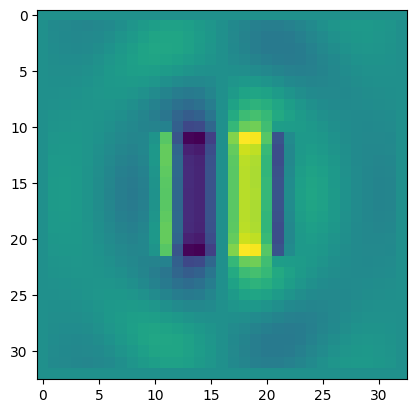

In [16]:
fields = data["cfield"]
dEx_r = fields[0]["Ex_r"]
plt.imshow(dEx_r[21*33*33:21*33*33+33*33].reshape(33,33))


In [12]:
fields[

{0: {'Ex_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Ex_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Ey_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Ey_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Ez_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Ez_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hx_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hx_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hy_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hy_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hz_r': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32),
  'Hz_i': array([0., 0., 0., ..., 0., 0., 0.], shape=(35937,), dtype=float32)}}

In [4]:
data['Planewave']

(90.0,
 0.0,
 -6.123233995736766e-17,
 -0.0,
 1.0,
 -0.0,
 1.0,
 0.0,
 -1.0,
 -0.0,
 -6.123233995736766e-17,
 0.3097730308019983,
 0.0,
 1.8968127531692084e-17,
 9448818897.637794,
 1)

In [7]:
data["Zn"]

array([-0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,
        0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,
        0.12,  0.13,  0.14,  0.15])

In [4]:
def read_fdtd_output(filename):
    data = {}

    with open(filename, "rb") as f:
        # Title (256文字)
        data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

        # int をまとめて読む（15個）
        ints = struct.unpack("15i", f.read(15 * 4))
        (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
         NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
         Solver_maxiter) = ints[:15]

        # 次の int
        Solver_nout = struct.unpack("i", f.read(4))[0]

        # double Dt
        Dt = struct.unpack("d", f.read(8))[0]

        # 3つの int
        (NGline, IPlanewave) = struct.unpack("2i", f.read(8))

        # --- planewave_t 読み込み ---
        # typedef struct {
        #   double theta, phi;
        #   double ei[3], hi[3];
        #   double ri[3], r0[3], ai;
        #   int pol;
        # } planewave_t;
        fmt = "2d 3d 3d 3d 3d d i"
        planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
        data["Planewave"] = planewave

        # --- 配列を numpy で読む ---
        def read_array(dtype, count):
            byte_size = np.dtype(dtype).itemsize * count
            return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)

        data["Xn"] = read_array(np.float64, Nx + 1)
        data["Yn"] = read_array(np.float64, Ny + 1)
        data["Zn"] = read_array(np.float64, Nz + 1)

        data["Xc"] = read_array(np.float64, Nx)
        data["Yc"] = read_array(np.float64, Ny)
        data["Zc"] = read_array(np.float64, Nz)

        data["Eiter"] = read_array(np.float64, Niter)
        data["Hiter"] = read_array(np.float64, Niter)

        data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
        data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
        data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))

        data["Freq1"] = read_array(np.float64, NFreq1)
        data["Freq2"] = read_array(np.float64, NFreq2)

        # --- feed_t 読み込み ---
        # feed_t {
        #   char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
        # }
        feed_fmt = "c 3i 3d 3d"
        feed_size = struct.calcsize(feed_fmt)
        Feed = []
        for _ in range(NFeed):
            Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
        data["Feed"] = Feed

        # complex (double,double)
        data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
        data["Ref"] = read_array(np.float64, NFeed * NFreq1)

        data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
        data["Pin1"] = read_array(np.float64, NFeed * NFreq2)

        data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
        data["Gline"] = read_array(np.float64, NGline * 2 * 3)

        # --- Surface ---
        NSurface = struct.unpack("i", f.read(4))[0]

        # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
        surf_fmt = "7d"
        surf_size = struct.calcsize(surf_fmt)
        Surface = []
        for _ in range(NSurface):
            Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
        data["Surface"] = Surface

        # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
        SurfaceData = {}
        for ifreq in range(NFreq2):
            SurfaceData[ifreq] = {
                "Ex": read_array(np.complex128, NSurface),
                "Ey": read_array(np.complex128, NSurface),
                "Ez": read_array(np.complex128, NSurface),
                "Hx": read_array(np.complex128, NSurface),
                "Hy": read_array(np.complex128, NSurface),
                "Hz": read_array(np.complex128, NSurface),
            }
        data["SurfaceFields"] = SurfaceData

        # --- cEx_r etc (float) ---
        c_fields = {}
        for ifreq in range(NFreq2):
            c_fields[ifreq] = {
                "Ex_r": read_array(np.float32, NN),
                "Ex_i": read_array(np.float32, NN),
                "Ey_r": read_array(np.float32, NN),
                "Ey_i": read_array(np.float32, NN),
                "Ez_r": read_array(np.float32, NN),
                "Ez_i": read_array(np.float32, NN),
                "Hx_r": read_array(np.float32, NN),
                "Hx_i": read_array(np.float32, NN),
                "Hy_r": read_array(np.float32, NN),
                "Hy_i": read_array(np.float32, NN),
                "Hz_r": read_array(np.float32, NN),
                "Hz_i": read_array(np.float32, NN),
            }
        data["cfield"] = c_fields

        # 最後の num
        data["num_written"] = struct.unpack("Q", f.read(8))[0]

    return data


In [37]:
filename = 'ofd.out'

data = {}
with open(filename, "rb") as f:
    # Title (256文字)
    data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

    # int をまとめて読む（15個） NNは8byte iではなくqにする
    fmt = "<iiiiiiiqiiiiiiiidii"
    sz = struct.calcsize(fmt)
    ints = struct.unpack(fmt, f.read(sz))
    (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
     NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
     Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]

    # --- planewave_t 読み込み ---
    # typedef struct {
    #   double theta, phi;
    #   double ei[3], hi[3];
    #   double ri[3], r0[3], ai;
    #   int pol;
    # } planewave_t;
    fmt = "2d 3d 3d 3d 3d d i"
    planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    data["Planewave"] = planewave

    # --- 配列を numpy で読む ---
    def read_array(dtype, count):
        byte_size = np.dtype(dtype).itemsize * count
        return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)

    data["Xn"] = read_array(np.float64, Nx + 1)
    data["Yn"] = read_array(np.float64, Ny + 1)
    data["Zn"] = read_array(np.float64, Nz + 1)

    data["Xc"] = read_array(np.float64, Nx)
    data["Yc"] = read_array(np.float64, Ny)
    data["Zc"] = read_array(np.float64, Nz)

    data["Eiter"] = read_array(np.float64, Niter)
    data["Hiter"] = read_array(np.float64, Niter)

    data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))

    data["Freq1"] = read_array(np.float64, NFreq1)
    data["Freq2"] = read_array(np.float64, NFreq2)

    # --- feed_t 読み込み ---
    # feed_t {
    #   char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
    # }
    feed_fmt = "c 3i 3d 3d"
    feed_size = struct.calcsize(feed_fmt)
    Feed = []
    for _ in range(NFeed):
        Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
    data["Feed"] = Feed

    # complex (double,double)
    data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
    data["Ref"] = read_array(np.float64, NFeed * NFreq1)

    data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
    data["Pin1"] = read_array(np.float64, NFeed * NFreq2)

    data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
    data["Gline"] = read_array(np.float64, NGline * 2 * 3)

    # --- Surface ---
    NSurface = struct.unpack("i", f.read(4))[0]

    # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
    surf_fmt = "7d"
    surf_size = struct.calcsize(surf_fmt)
    Surface = []
    for _ in range(NSurface):
        Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
    data["Surface"] = Surface

    # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
    SurfaceData = {}
    for ifreq in range(NFreq2):
        SurfaceData[ifreq] = {
            "Ex": read_array(np.complex128, NSurface),
            "Ey": read_array(np.complex128, NSurface),
            "Ez": read_array(np.complex128, NSurface),
            "Hx": read_array(np.complex128, NSurface),
            "Hy": read_array(np.complex128, NSurface),
            "Hz": read_array(np.complex128, NSurface),
        }
    data["SurfaceFields"] = SurfaceData

    # --- cEx_r etc (float) ---
    c_fields = {}
    for ifreq in range(NFreq2):
        c_fields[ifreq] = {
            "Ex_r": read_array(np.float32, NN),
            "Ex_i": read_array(np.float32, NN),
            "Ey_r": read_array(np.float32, NN),
            "Ey_i": read_array(np.float32, NN),
            "Ez_r": read_array(np.float32, NN),
            "Ez_i": read_array(np.float32, NN),
            "Hx_r": read_array(np.float32, NN),
            "Hx_i": read_array(np.float32, NN),
            "Hy_r": read_array(np.float32, NN),
            "Hy_i": read_array(np.float32, NN),
            "Hz_r": read_array(np.float32, NN),
            "Hz_i": read_array(np.float32, NN),
        }
    data["cfield"] = c_fields

    # 最後の num
    data["num_written"] = struct.unpack("Q", f.read(8))[0]




error: unpack requires a buffer of 56 bytes

In [38]:
print(N0)
print(NN)
print(NFreq1)
print(NFreq2)
print(NFeed)
print(Ntime)
print(Solver_maxiter)
print(Solver_nout)
print(Dt)
print(NGline)
print(IPlanewave)

1123
35937
1
1
0
301
1000
50
1.9258332015464616e-11
12
1


In [41]:
data["Planewave"]

(90.0,
 0.0,
 -6.123233995736766e-17,
 -0.0,
 1.0,
 -0.0,
 1.0,
 0.0,
 -1.0,
 -0.0,
 -6.123233995736766e-17,
 0.3097730308019983,
 0.0,
 1.8968127531692084e-17,
 9448818897.637794,
 1)

In [14]:
NFreq1

1

In [15]:
NFreq2

1

In [16]:
NFeed

0

(5.332997387e-315,
 1.2372789683832655e-62,
 1.563056641e-314,
 1.0609978955e-314,
 5.299808824e-315,
 1.0609978955e-314,
 5.299808824e-315,
 0.0,
 1.590978778e-314,
 1.2372794320340343e-62,
 2149944381434249.5,
 5.29068617e-315,
 5.3347677554549794e-68,
 7.3783247130493585e+31,
 2.6691246306e-314,
 0)

In [2]:
def checkdata(data):
    print(f'title={data['Title']}')
    # print('N0={data['N0']}', ' ', data['NN'], ' ', data['NFreq1'], ' ', data['nout'],' ', data['Dt'], ' ', data['NGline'])
    print(f'Nx={data['Nx']}, Ny={data['Ny']}, Nz={data['Nz']}, Ni={data['Ni']}, Nj={data['Nj']}, Nk={data['Nk']}, N0={data['N0']}')
    print(f'NN={data['NN']}, NFreq1={data['NFreq1']}, NFreq2={data['NFreq2']}, NFeed={data['NFeed']}, NPoint={data['NPoint']}')
    print(f'Niter={data['Niter']}') 
    
